In [1]:
import math
import numpy as np
import pandas as pd
import scipy as sc
import matplotlib.pyplot as plt
from scipy.integrate import quad, trapz

import scipy.stats
import scipy.optimize
from scipy.signal import find_peaks

%pylab inline

from lmfit import minimize, Parameters, Model

import sklearn
from sklearn.model_selection import ParameterGrid
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


Text(0,0.5,'Counts')

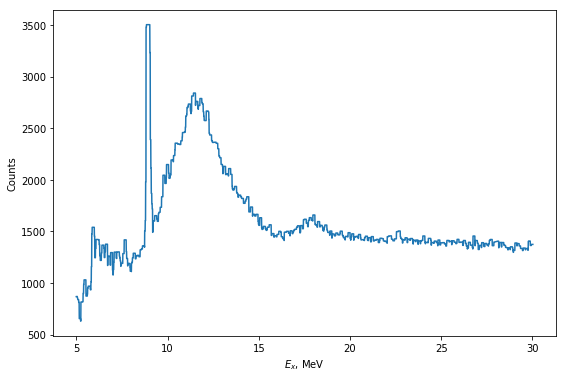

In [2]:
Ga_5_28 = pd.read_csv('../B(GT) peaks processing/recognition/Ga/plots/2015/5_28.csv', 
                      sep='\t', decimal=',')

plt.figure(figsize=(9,6))
plt.plot(Ga_5_28['x'].values, Ga_5_28['y'].values)
plt.xlabel('$E_x$, MeV')
plt.ylabel('Counts')
#plt.ylim(0,6)

Text(0,0.5,'Counts')

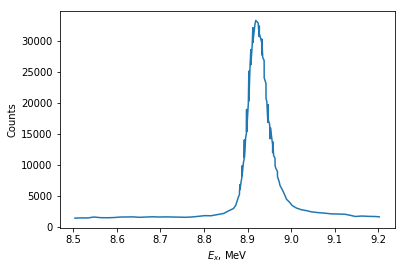

In [3]:
IAS = pd.read_csv('../B(GT) peaks processing/recognition/Ga/plots/2015/IAS.csv', 
                      sep='\t', decimal=',')
IAS['y'] = IAS['y'] * 1000
plt.plot(IAS['x'].values, IAS['y'].values)
plt.xlabel('$E_x$, MeV')
plt.ylabel('Counts')
#plt.xlim(8.9,9)

Text(0,0.5,'Counts')

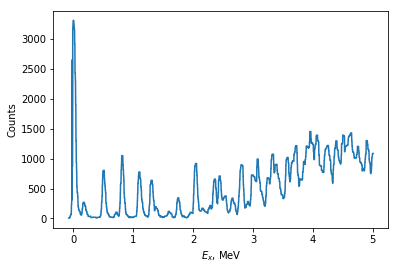

In [4]:
Ga_0_5 = pd.read_csv('../B(GT) peaks processing/recognition/Ga/plots/2015/0_5.csv', 
                      sep='\t', decimal=',')
plt.plot(Ga_0_5['x'].values, Ga_0_5['y'].values)
plt.xlabel('$E_x$, MeV')
plt.ylabel('Counts')

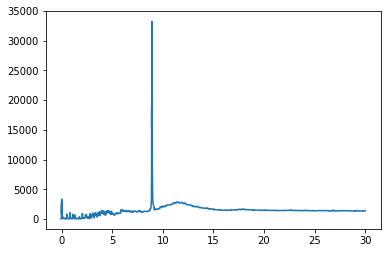

In [5]:
beginning = Ga_5_28[((Ga_5_28['x']<8.7))]
middle = IAS[((IAS['x']>8.7) & (IAS['x']<9.18))]
ending = Ga_5_28[((Ga_5_28['x']>9.18))]

data = Ga_0_5.append(beginning).append(middle).append(ending)

plt.plot(data['x'].values, data['y'].values)

(0, 20)

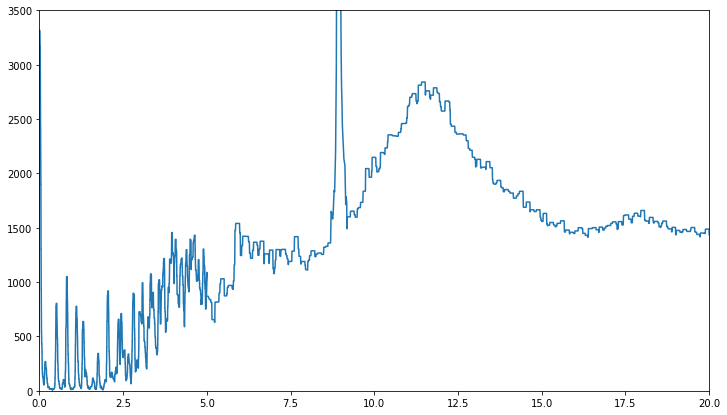

In [6]:
plt.figure(figsize=(12,7))
plt.plot(data['x'].values, data['y'].values)
plt.ylim(0,3500)
plt.xlim(0,20)

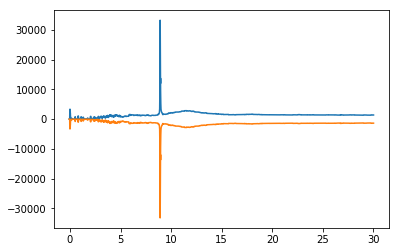

In [7]:
plt.plot(data['x'].values, data['y'].values)
plt.plot(data['x'].values, -data['y'].values)

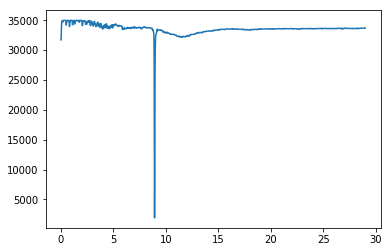

In [8]:
x_data = np.linspace(0,29,len(data['x'].values))
y_data = np.interp(x_data, data['x'].values, data['y'].values)
#plt.plot(x_data, y_data)
plt.plot(x_data, -y_data+35000)

(0, 5000)

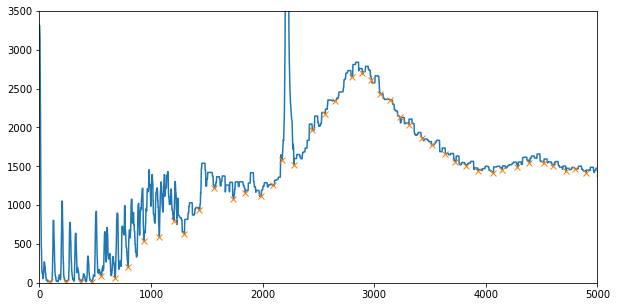

In [9]:
peaks, _ = sc.signal.find_peaks(-y_data+35000, distance=80)
plt.figure(figsize=(10,5))
plt.plot(y_data)
plt.plot(peaks, y_data[peaks], "x")
plt.ylim(0,3500)
plt.xlim(0,5000)

(8.7, 9.2)

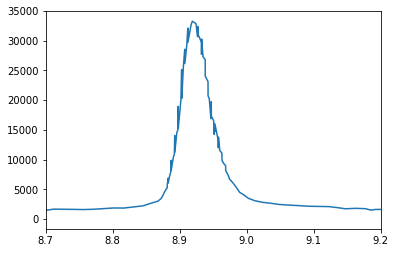

In [10]:
plt.plot(data['x'].values, data['y'].values)
plt.xlim(8.7,9.2)

(8.5, 9.2)

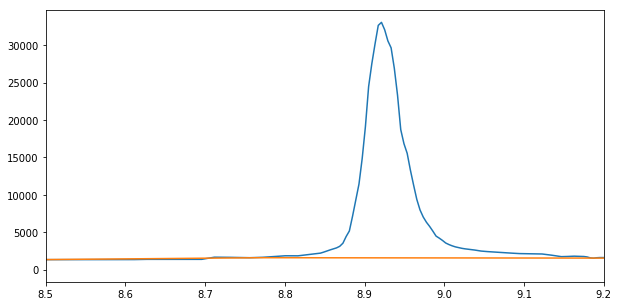

In [11]:
y_data2 = np.interp(x_data, x_data[peaks], y_data[peaks])
plt.figure(figsize=(10,5))
plt.plot(x_data, y_data)
plt.plot(x_data, y_data2)
plt.xlim(8.5,9.2)

(0, 3500)

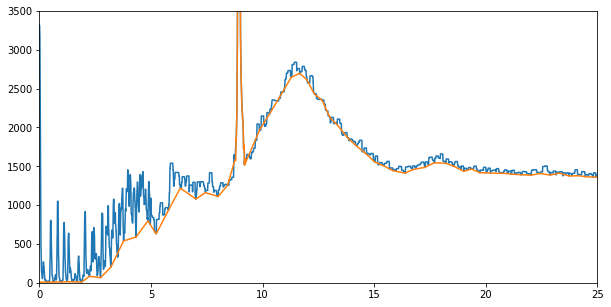

In [31]:
temp1 = pd.DataFrame({'x':x_data, 'y':y_data})
temp2 = pd.DataFrame({'x':x_data, 'y':y_data2})

data3 = temp2[(temp2['x']<8.8)].append(temp1[((temp1['x']>8.8) & (temp1['x']<9.2))]).append(temp2[(temp2['x']>9.2)])

plt.figure(figsize=(10,5))
plt.plot(temp1['x'].values, temp1['y'].values)
plt.plot(data3['x'].values, data3['y'].values)
plt.xlim(0,25)
plt.ylim(0,3500)

In [13]:
def gauss(x, mu, sigma, k):
    return k*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sigma, 2.)))

def breit_vigner2(x, M, w = 11.3, alpha = 0.018):
    G = alpha * (w ** 2) + 1
    #G = alpha * (w ** 2)
    y = M * (G**1) * (1-np.exp(-(x/G)**2) ) / ((x - w)**2 + (G**2)/1)
    return np.round(y, decimals=5) #округляем чтобы убрать неустойчивость расчета изза хвостов

def breit_vigner3(x, M, w,  G1):
    G = G1
    y = M * (G**1) * (1-np.exp(-(x/G)**2) ) / ((x - w)**2 + (G**2)/1)
    return np.round(y, decimals=5) #округляем чтобы убрать неустойчивость расчета изза хвостов

In [16]:
def QFC_back3(x, E_qf, N_0, W, T):
    Q_EC_76As=0.9233
    S_p_76As=7.723
    E_t_gs = 420 - Q_EC_76As
    E_0 = E_t_gs - S_p_76As
    E = E_t_gs - x
    
    values = N_0 * ( 1 - np.exp((E-E_0)/T) )/( 1 + ((E-E_qf)/W)**2)
    values_more0 = values[ np.where(values>0) ]
    beginning = np.zeros((len(x)-len(values_more0)))
    return np.concatenate((beginning, values_more0))

def QFC_back4(x, E_qf, N_0):
    W = 22
    T = 100
    Q_EC_71Ge=0.232
    S_p_71Ge=8.285
    E_t_gs = 420 - Q_EC_71Ge
    E_0 = E_t_gs - S_p_71Ge
    E = E_t_gs - x
    
    values = N_0 * ( 1 - np.exp((E-E_0)/T) )/( 1 + ((E-E_qf)/W)**2)
    values_more0 = values[ np.where(values>0) ]
    beginning = np.zeros((len(x)-len(values_more0)))
    return np.concatenate((beginning, values_more0))

In [26]:
#np.random.seed(150)

total_mod = Model(breit_vigner3,prefix='pigmy1_') \
+Model(breit_vigner3,prefix='pigmy2_') \
+Model(breit_vigner3,prefix='IAS1_') \
+Model(breit_vigner3, prefix='GTR_') \
+Model(breit_vigner3, prefix='SDR_') \
+Model(QFC_back4, prefix='QFC_back_')

total_mod.set_param_hint('pigmy1_w', value=4.5, min=3, max=5)
total_mod.set_param_hint('pigmy1_G1', value=0.1, min=0.1, max=3)
total_mod.set_param_hint('pigmy1_M', value=5, min=1, max=5000)

total_mod.set_param_hint('pigmy2_w', value=6, min=4, max=8)
total_mod.set_param_hint('pigmy2_G1', value=0.1, min=0.1, max=5)
total_mod.set_param_hint('pigmy2_M', value=1, min=1, max=5000)

total_mod.set_param_hint('IAS1_w', value=8.913, min=8.8, max=9.1) #возможно ошибка в оцифровке, если фиксировать значение, то пик получается смещенным
total_mod.set_param_hint('IAS1_G1', value=0.01, min=0.01, max=0.04)
total_mod.set_param_hint('IAS1_M', value=0.5, min=0.5, max=5000)

total_mod.set_param_hint('GTR_w', value=11.75, min=11, max=13)
total_mod.set_param_hint('GTR_G1', value=2, min=2, max=5)
total_mod.set_param_hint('GTR_M', value=0.5, min=0.1, max= 10000)

total_mod.set_param_hint('SDR_w', value=15, min=12, max=20)
total_mod.set_param_hint('SDR_G1', value=0.01, min=0.1, max=10)
total_mod.set_param_hint('SDR_M', value=0.5, min=0.1, max= 3000)

total_mod.set_param_hint('QFC_back_E_qf', value=400, max=410, min=380 )
total_mod.set_param_hint('QFC_back_N_0', value=8, min=1, max=15000 )

pars = total_mod.make_params()

total_mod_result = total_mod.fit(data3['y'].values, pars, x=data3['x'].values, 
                                 method='differential_evolution')

print(total_mod_result.fit_report())

[[Model]]
    (((((Model(breit_vigner3, prefix='pigmy1_') + Model(breit_vigner3, prefix='pigmy2_')) + Model(breit_vigner3, prefix='IAS1_')) + Model(breit_vigner3, prefix='GTR_')) + Model(breit_vigner3, prefix='SDR_')) + Model(QFC_back4, prefix='QFC_back_'))
[[Fit Statistics]]
    # function evals   = 43897
    # data points      = 7198
    # variables        = 17
    chi-square         = 154685539.596
    reduced chi-square = 21540.947
    Akaike info crit   = 71836.543
    Bayesian info crit = 71953.530
[[Variables]]
    pigmy1_M:        200.564093 (init= 5)
    pigmy1_w:        4.54549675 (init= 4.5)
    pigmy1_G1:       0.71523742 (init= 0.1)
    pigmy2_M:        768.689773 (init= 1)
    pigmy2_w:        6.57530568 (init= 6)
    pigmy2_G1:       1.09686855 (init= 0.1)
    IAS1_M:          741.232916 (init= 0.5)
    IAS1_w:          8.92393790 (init= 8.913)
    IAS1_G1:         0.02210945 (init= 0.01)
    GTR_M:           5337.38575 (init= 0.5)
    GTR_w:           11.4142051 (init= 

(0, 3500)

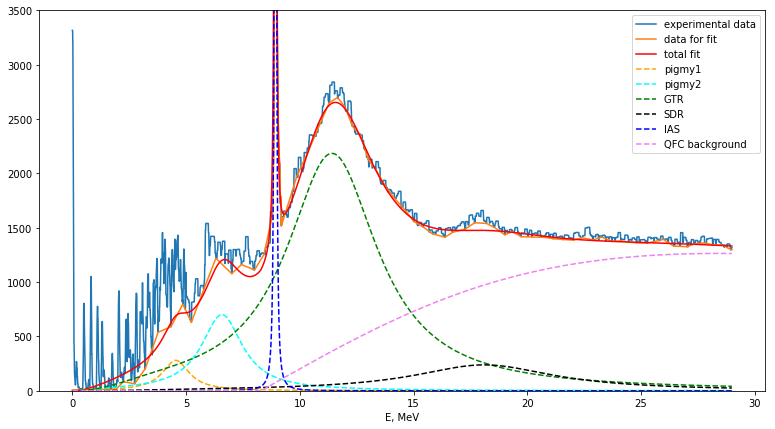

In [35]:
total_mod_comps = total_mod_result.eval_components()

plt.figure(figsize=(13,7))
#plt.plot(data['x'].values, data['y'].values)
plt.plot(temp1['x'].values, temp1['y'].values, label='experimental data')
plt.plot(data3['x'].values, data3['y'].values, label='data for fit')
plt.plot(data3['x'].values, total_mod_result.best_fit, 'r-', label='total fit')
plt.plot(data3['x'].values, total_mod_comps['pigmy1_'], 'orange', label='pigmy1', ls='--')
plt.plot(data3['x'].values, total_mod_comps['pigmy2_'], 'cyan', label='pigmy2', ls='--')
plt.plot(data3['x'].values, total_mod_comps['GTR_'], 'g--', label='GTR')
plt.plot(data3['x'].values, total_mod_comps['SDR_'], 'black', label='SDR', ls='--')
plt.plot(data3['x'].values, total_mod_comps['IAS1_'], 'b--', label='IAS ')
plt.plot(data3['x'].values, total_mod_comps['QFC_back_'], 'violet', label='QFC background', ls='--')
#plt.plot(IAS_red['x'].values, comps['line_'], 'b--')
plt.legend()
plt.xlabel('E, MeV')
#plt.ylabel('S(E), 1/MeV')
plt.ylim(0,3500)

(8.5, 9.2)

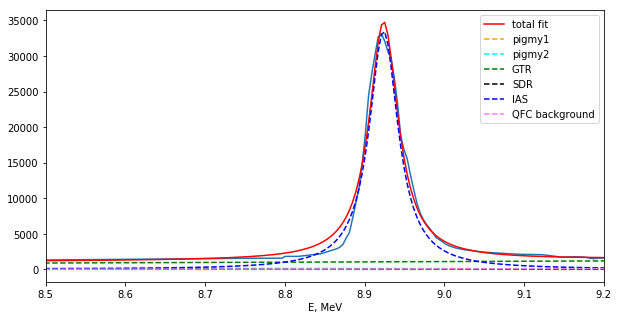

In [28]:
plt.figure(figsize=(10,5))
#plt.plot(data['x'].values, data['y'].values)
plt.plot(data3['x'].values, data3['y'].values)
#plt.plot(temp2['x'].values, temp2['y'].values)
plt.plot(data3['x'].values, total_mod_result.best_fit, 'r-', label='total fit')
plt.plot(data3['x'].values, total_mod_comps['pigmy1_'], 'orange', label='pigmy1', ls='--')
plt.plot(data3['x'].values, total_mod_comps['pigmy2_'], 'cyan', label='pigmy2', ls='--')
plt.plot(data3['x'].values, total_mod_comps['GTR_'], 'g--', label='GTR')
plt.plot(data3['x'].values, total_mod_comps['SDR_'], 'black', label='SDR', ls='--')
plt.plot(data3['x'].values, total_mod_comps['IAS1_'], 'b--', label='IAS ')
plt.plot(data3['x'].values, total_mod_comps['QFC_back_'], 'violet', label='QFC background', ls='--')
#plt.plot(IAS_red['x'].values, comps['line_'], 'b--')
plt.legend()
plt.xlabel('E, MeV')
#plt.ylabel('S(E), 1/MeV')
plt.xlim(8.5,9.2)

In [40]:
#    SDR_M:           4.24617815 (init= 0.5)
#    SDR_w:           18.1722273 (init= 18.5)
#    SDR_G1:          9.69232074 (init= 0.1)
#    QFC_back_E_qf:   396.677843 (init= 400)
#    QFC_back_N_0:    6.00781341 (init= 8)
        
        
#SDR_M = np.linspace(4.0, 4.5, 3)
#SDR_w = np.linspace(18, 19, 3)
SDR_M = np.array([4.25])
SDR_w = np.array([18.5])
SDR_G1 = np.linspace(9, 10, 3)

QFC_back_E_qf = np.linspace(370, 410, 5)
QFC_back_N_0 = np.linspace(6,8, 3)

params_grid = {'SDR_M':SDR_M, 'SDR_w':SDR_w, 'SDR_G1':SDR_G1, 
               'QFC_back_E_qf': QFC_back_E_qf, 'QFC_back_N_0':QFC_back_N_0}
params_list = list(ParameterGrid(params_grid)) 
params_list

[{'QFC_back_E_qf': 370.0,
  'QFC_back_N_0': 6.0,
  'SDR_G1': 9.0,
  'SDR_M': 4.25,
  'SDR_w': 18.5},
 {'QFC_back_E_qf': 370.0,
  'QFC_back_N_0': 6.0,
  'SDR_G1': 9.5,
  'SDR_M': 4.25,
  'SDR_w': 18.5},
 {'QFC_back_E_qf': 370.0,
  'QFC_back_N_0': 6.0,
  'SDR_G1': 10.0,
  'SDR_M': 4.25,
  'SDR_w': 18.5},
 {'QFC_back_E_qf': 370.0,
  'QFC_back_N_0': 7.0,
  'SDR_G1': 9.0,
  'SDR_M': 4.25,
  'SDR_w': 18.5},
 {'QFC_back_E_qf': 370.0,
  'QFC_back_N_0': 7.0,
  'SDR_G1': 9.5,
  'SDR_M': 4.25,
  'SDR_w': 18.5},
 {'QFC_back_E_qf': 370.0,
  'QFC_back_N_0': 7.0,
  'SDR_G1': 10.0,
  'SDR_M': 4.25,
  'SDR_w': 18.5},
 {'QFC_back_E_qf': 370.0,
  'QFC_back_N_0': 8.0,
  'SDR_G1': 9.0,
  'SDR_M': 4.25,
  'SDR_w': 18.5},
 {'QFC_back_E_qf': 370.0,
  'QFC_back_N_0': 8.0,
  'SDR_G1': 9.5,
  'SDR_M': 4.25,
  'SDR_w': 18.5},
 {'QFC_back_E_qf': 370.0,
  'QFC_back_N_0': 8.0,
  'SDR_G1': 10.0,
  'SDR_M': 4.25,
  'SDR_w': 18.5},
 {'QFC_back_E_qf': 380.0,
  'QFC_back_N_0': 6.0,
  'SDR_G1': 9.0,
  'SDR_M': 4.25,
  'SD

In [67]:
len(params_list)

45

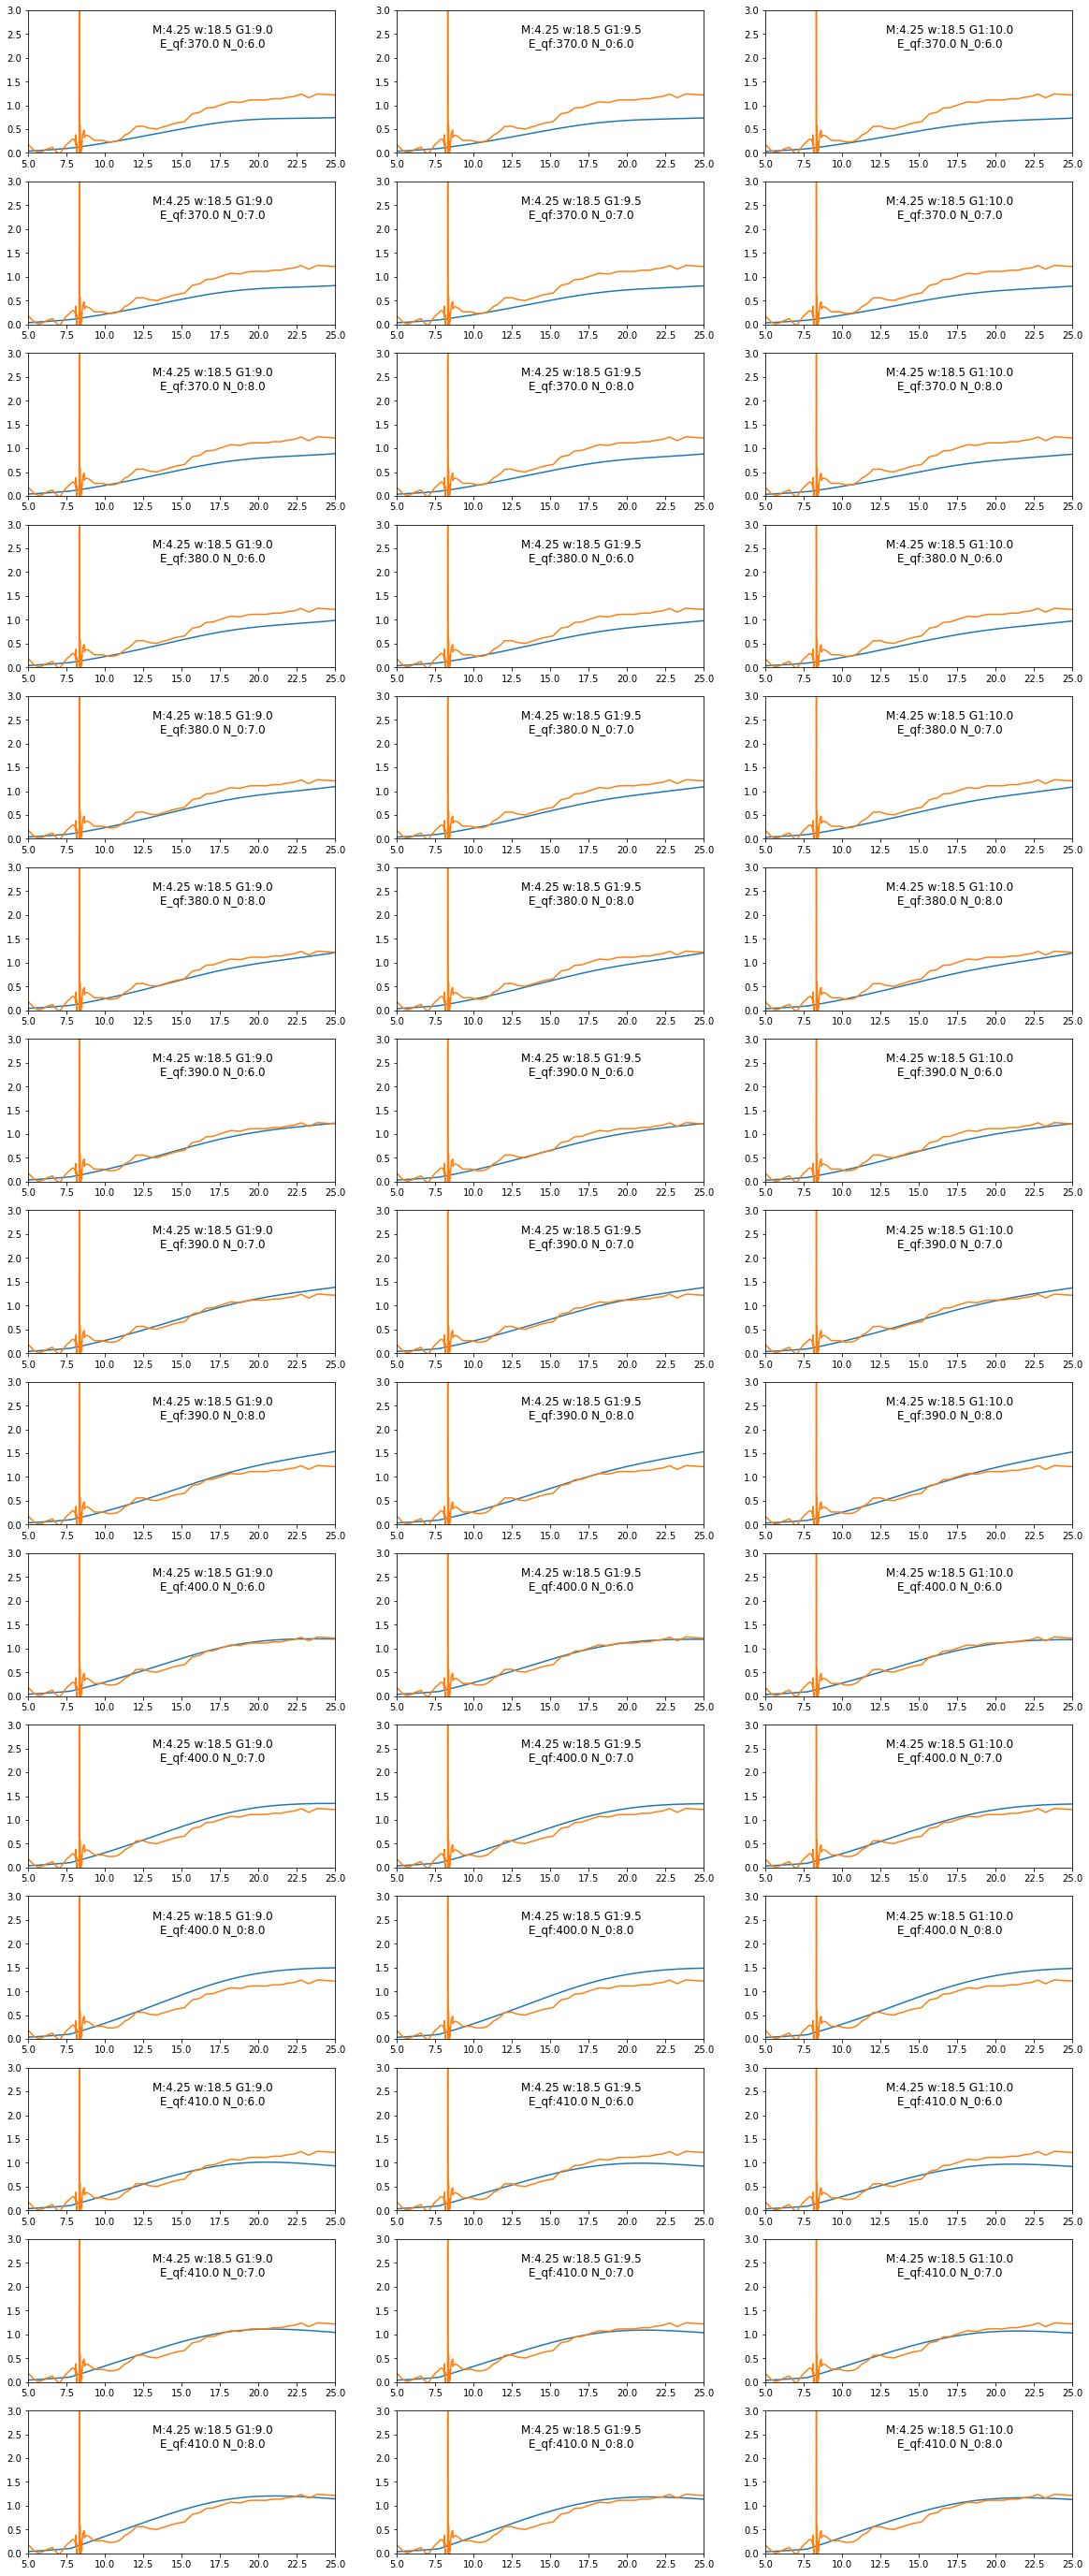

In [84]:
fig = plt.figure(figsize=(20,50))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
Y_LIM = [[0,4]] * len(params_list)

a = total_mod_comps['pigmy1_']\
+total_mod_comps['pigmy2_']\
+total_mod_comps['pigmy3_']\
+total_mod_comps['IAS1_']\
+total_mod_comps['IAS2_']\
+total_mod_comps['GTR_']
out = total_mod_result.best_fit-a
out1 = data3['y'].values-a

for i, param in enumerate(params_list):
    ax = fig.add_subplot(len(params_list)//3, 3, i+1)
    #ax.plot(data3['x'].values, data3['y'].values)
    
    SDR = breit_vigner3(data3['x'].values, param['SDR_M'], param['SDR_w'], param['SDR_G1'])
    E_qf = QFC_back3(data3['x'].values, param['QFC_back_E_qf'], param['QFC_back_N_0'], 22, 100)
    tail = SDR + E_qf
    
    ax.plot(data3['x'].values, tail)
    ax.plot(data3['x'].values, out1)
    ax.set_ylim(0,3)
    ax.set_xlim(5,25)
    title = 'M:'+str(param['SDR_M'])+' '+'w:'+str(param['SDR_w'])+' '\
    +'G1:'+str(param['SDR_G1'])+'\n'+'E_qf:'+str(param['QFC_back_E_qf'])+' '\
    +'N_0:'+str(param['QFC_back_N_0'])
    ax.set_title(title)
    ax.title.set_position([0.6,0.7])

plt.savefig("subplots.png", transparent=False, dpi=120)

In [37]:
output=pd.DataFrame(data={'x':data3['x'].values.T, 'y':out.T, 
                          'GTR':total_mod_comps['GTR_'].T, 
                         'PR1':total_mod_comps['pigmy1_'].T,
                         'PR2':total_mod_comps['pigmy2_'].T,
                         'PR3':total_mod_comps['pigmy3_'].T})
output.head()              

,GTR,PR1,PR2,PR3,x,y
0,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000
1,0.00000,0.00000,0.00000,0.00000,0.005724,0.00000
2,0.00000,0.00000,0.00000,0.00000,0.011447,0.00000
3,0.00001,0.00000,0.00000,0.00000,0.017171,0.00001
4,0.00001,0.00001,0.00001,0.00001,0.022895,0.00004


In [38]:
#output.to_csv('best_fit_3PR-SDR-IAS-QFC.csv')

In [18]:
np.random.seed(1150)

total_mod = Model(breit_vigner3,prefix='pigmy1_') \
+Model(breit_vigner3,prefix='pigmy2_') \
+Model(breit_vigner3,prefix='pigmy3_') \
+Model(breit_vigner3,prefix='IAS1_') \
+Model(breit_vigner3,prefix='IAS2_') \
+Model(gauss, prefix='GTR_') \
+Model(breit_vigner3, prefix='SDR_') \
+Model(QFC_back3, prefix='QFC_back_')

total_mod.set_param_hint('pigmy1_w', value=2, min=1, max=4)
total_mod.set_param_hint('pigmy1_G1', value=0.1, min=0.1, max=0.6)
total_mod.set_param_hint('pigmy1_M', value=0.1, min=0.1, max=0.4)

total_mod.set_param_hint('pigmy2_w', value=3, min=2, max=6)
total_mod.set_param_hint('pigmy2_G1', value=0.1, min=0.1, max=1)
total_mod.set_param_hint('pigmy2_M', value=0.1, min=0.3, max=0.6)

total_mod.set_param_hint('pigmy3_w', value=6, min=5, max=7)
total_mod.set_param_hint('pigmy3_G1', value=0.1, min=0.1, max=1)
total_mod.set_param_hint('pigmy3_M', value=0.1, min=0.5, max=0.8)

total_mod.set_param_hint('IAS1_w', value=8.308, vary=False)
total_mod.set_param_hint('IAS1_G1', value=0.01, min=0.01, max=0.02)
total_mod.set_param_hint('IAS1_M', value=0.5, min=0.5, max=0.7)
total_mod.set_param_hint('IAS2_w', value=8.36, vary=False)
total_mod.set_param_hint('IAS2_G1', value=0.03, min=0.01, max=0.05)
total_mod.set_param_hint('IAS2_M', value=0.1, min=0.1, max=0.5)

total_mod.set_param_hint('GTR_mu', value=11.0, min=11, max=11.5)
total_mod.set_param_hint('GTR_sigma', value=2, min=0.1, max=20)
total_mod.set_param_hint('GTR_k', value=0.5, min=0.1, max= 50)

total_mod.set_param_hint('SDR_w', value=18.5, min=18, max=19)
total_mod.set_param_hint('SDR_G1', value=0.01, min=0.1, max=10)
total_mod.set_param_hint('SDR_M', value=0.5, min=0.1, max= 5)

total_mod.set_param_hint('QFC_back_E_qf', value=400, max=410, min=380 )
total_mod.set_param_hint('QFC_back_N_0', value=8, max=15, min=1 )
total_mod.set_param_hint('QFC_back_W', value=22, vary=False)
total_mod.set_param_hint('QFC_back_T', value=100,vary=False)

pars = total_mod.make_params()

total_mod_result = total_mod.fit(data3['y'].values, pars, x=data3['x'].values, 
                                 method='differential_evolution')

print(total_mod_result.fit_report())

[[Model]]
    (((((((Model(breit_vigner3, prefix='pigmy1_') + Model(breit_vigner3, prefix='pigmy2_')) + Model(breit_vigner3, prefix='pigmy3_')) + Model(breit_vigner3, prefix='IAS1_')) + Model(breit_vigner3, prefix='IAS2_')) + Model(gauss, prefix='GTR_')) + Model(breit_vigner3, prefix='SDR_')) + Model(QFC_back3, prefix='QFC_back_'))
[[Fit Statistics]]
    # function evals   = 39069
    # data points      = 4893
    # variables        = 21
    chi-square         = 156.475
    reduced chi-square = 0.032
    Akaike info crit   = -16802.969
    Bayesian info crit = -16666.562
[[Variables]]
    pigmy1_M:        0.13632985 (init= 0.1)
    pigmy1_w:        3.61543017 (init= 2)
    pigmy1_G1:       0.57949684 (init= 0.1)
    pigmy2_M:        0.57328830 (init= 0.3)
    pigmy2_w:        5.27854522 (init= 3)
    pigmy2_G1:       0.88186544 (init= 0.1)
    pigmy3_M:        0.78719150 (init= 0.5)
    pigmy3_w:        6.53577107 (init= 6)
    pigmy3_G1:       0.99768456 (init= 0.1)
    IAS1_M:       

(0, 6)

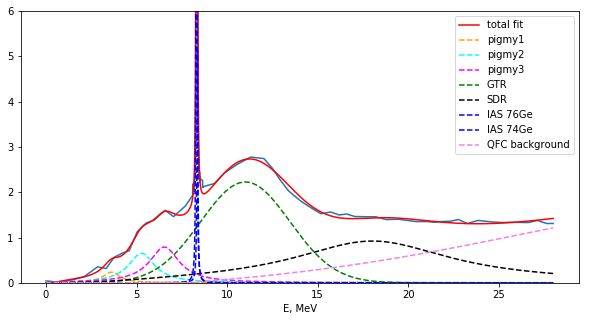

In [19]:
total_mod_comps = total_mod_result.eval_components()

plt.figure(figsize=(10,5))
#plt.plot(data['x'].values, data['y'].values)
plt.plot(data3['x'].values, data3['y'].values)
#plt.plot(temp2['x'].values, temp2['y'].values)
plt.plot(data3['x'].values, total_mod_result.best_fit, 'r-', label='total fit')
plt.plot(data3['x'].values, total_mod_comps['pigmy1_'], 'orange', label='pigmy1', ls='--')
plt.plot(data3['x'].values, total_mod_comps['pigmy2_'], 'cyan', label='pigmy2', ls='--')
plt.plot(data3['x'].values, total_mod_comps['pigmy3_'], 'magenta', label='pigmy3', ls='--')
plt.plot(data3['x'].values, total_mod_comps['GTR_'], 'g--', label='GTR')
plt.plot(data3['x'].values, total_mod_comps['SDR_'], 'black', label='SDR', ls='--')
plt.plot(data3['x'].values, total_mod_comps['IAS1_'], 'b--', label='IAS 76Ge')
plt.plot(data3['x'].values, total_mod_comps['IAS2_'], 'b--', label='IAS 74Ge')
plt.plot(data3['x'].values, total_mod_comps['QFC_back_'], 'violet', label='QFC background', ls='--')
#plt.plot(IAS_red['x'].values, comps['line_'], 'b--')
plt.legend()
plt.xlabel('E, MeV')
#plt.ylabel('S(E), 1/MeV')
plt.ylim(0,6)

(0, 6)

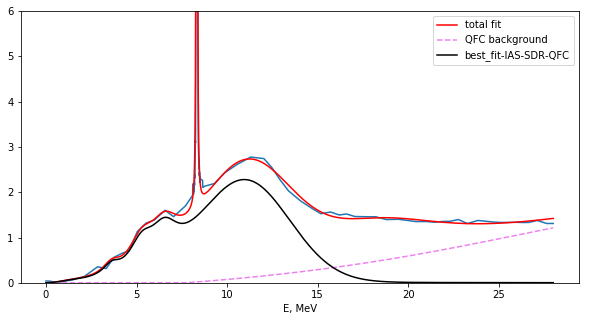

In [20]:
total_mod_comps = total_mod_result.eval_components()

plt.figure(figsize=(10,5))
#plt.plot(data['x'].values, data['y'].values)
plt.plot(data3['x'].values, data3['y'].values)
#plt.plot(temp2['x'].values, temp2['y'].values)
plt.plot(data3['x'].values, total_mod_result.best_fit, 'r-', label='total fit')
#plt.plot(data3['x'].values, total_mod_comps['pigmy1_'], 'orange', label='pigmy1', ls='--')
#plt.plot(data3['x'].values, total_mod_comps['pigmy2_'], 'cyan', label='pigmy2', ls='--')
#plt.plot(data3['x'].values, total_mod_comps['pigmy3_'], 'magenta', label='pigmy3', ls='--')
#plt.plot(data3['x'].values, total_mod_comps['GTR_'], 'g--', label='GTR')
#plt.plot(data3['x'].values, total_mod_comps['SDR_'], 'black', label='SDR', ls='--')
#plt.plot(data3['x'].values, total_mod_comps['IAS1_'], 'b--', label='IAS 76Ge')
#plt.plot(data3['x'].values, total_mod_comps['IAS2_'], 'b--', label='IAS 74Ge')

a = total_mod_comps['QFC_back_']+total_mod_comps['SDR_']+total_mod_comps['IAS1_']+total_mod_comps['IAS2_']
out = total_mod_result.best_fit-a

plt.plot(data3['x'].values, total_mod_comps['QFC_back_'], 'violet', label='QFC background', ls='--')
#plt.plot(IAS_red['x'].values, comps['line_'], 'b--')
plt.plot(data3['x'].values, out, c='black', label='best_fit-IAS-SDR-QFC' )
plt.xlabel('E, MeV')
plt.legend()
plt.ylim(0,6)
plt.legend()
plt.xlabel('E, MeV')
#plt.ylabel('S(E), 1/MeV')
plt.ylim(0,6)

In [21]:
output=pd.DataFrame(data={'x':data3['x'].values.T, 'y':out.T, 
                          'GTR_gauss':total_mod_comps['GTR_'].T, 
                         'PR1':total_mod_comps['pigmy1_'].T,
                         'PR2':total_mod_comps['pigmy2_'].T,
                         'PR3':total_mod_comps['pigmy3_'].T})
output.head() 
#output.to_csv('3pigmy_gauss-SDR-IAS-QFC.csv')

,GTR_gauss,PR1,PR2,PR3,x,y
0,0.000105,0.00000,0.00000,0.00000,0.000000,0.000105
1,0.000106,0.00000,0.00000,0.00000,0.005724,0.000106
2,0.000107,0.00000,0.00000,0.00000,0.011447,0.000107
3,0.000108,0.00001,0.00001,0.00001,0.017171,0.000138
4,0.000109,0.00001,0.00001,0.00001,0.022895,0.000139


In [22]:
output.head()

,GTR_gauss,PR1,PR2,PR3,x,y
0,0.000105,0.00000,0.00000,0.00000,0.000000,0.000105
1,0.000106,0.00000,0.00000,0.00000,0.005724,0.000106
2,0.000107,0.00000,0.00000,0.00000,0.011447,0.000107
3,0.000108,0.00001,0.00001,0.00001,0.017171,0.000138
4,0.000109,0.00001,0.00001,0.00001,0.022895,0.000139


In [23]:
np.random.seed(250)

total_mod = Model(breit_vigner3,prefix='pigmy2_') \
+Model(breit_vigner3,prefix='pigmy3_') \
+Model(breit_vigner3,prefix='IAS1_') \
+Model(breit_vigner3,prefix='IAS2_') \
+Model(breit_vigner3, prefix='GTR_') \
+Model(breit_vigner3, prefix='SDR_') \
+Model(QFC_back3, prefix='QFC_back_')

total_mod.set_param_hint('pigmy2_w', value=3, min=1, max=6)
total_mod.set_param_hint('pigmy2_G1', value=0.1, min=0.1, max=1)
total_mod.set_param_hint('pigmy2_M', value=0.1, min=0.3, max=0.6)

total_mod.set_param_hint('pigmy3_w', value=6, min=4, max=7)
total_mod.set_param_hint('pigmy3_G1', value=0.1, min=0.1, max=1.5)
total_mod.set_param_hint('pigmy3_M', value=0.1, min=0.5, max=1)

total_mod.set_param_hint('IAS1_w', value=8.308, vary=False)
total_mod.set_param_hint('IAS1_G1', value=0.01, min=0.01, max=0.02)
total_mod.set_param_hint('IAS1_M', value=0.5, min=0.5, max=0.7)
total_mod.set_param_hint('IAS2_w', value=8.36, vary=False)
total_mod.set_param_hint('IAS2_G1', value=0.03, min=0.01, max=0.05)
total_mod.set_param_hint('IAS2_M', value=0.1, min=0.1, max=0.5)

total_mod.set_param_hint('GTR_w', value=11.0, min=11, max=11.5)
total_mod.set_param_hint('GTR_G1', value=2, min=2, max=4)
total_mod.set_param_hint('GTR_M', value=0.5, min=0.1, max= 50)

total_mod.set_param_hint('SDR_w', value=18.5, min=18, max=19)
total_mod.set_param_hint('SDR_G1', value=0.01, min=0.1, max=10)
total_mod.set_param_hint('SDR_M', value=0.5, min=0.1, max= 5)

total_mod.set_param_hint('QFC_back_E_qf', value=400, max=410, min=380 )
total_mod.set_param_hint('QFC_back_N_0', value=8, max=15, min=1 )
total_mod.set_param_hint('QFC_back_W', value=22, vary=False)
total_mod.set_param_hint('QFC_back_T', value=100,vary=False)

pars = total_mod.make_params()

total_mod_result = total_mod.fit(data3['y'].values, pars, x=data3['x'].values, 
                                 method='differential_evolution')

print(total_mod_result.fit_report())

[[Model]]
    ((((((Model(breit_vigner3, prefix='pigmy2_') + Model(breit_vigner3, prefix='pigmy3_')) + Model(breit_vigner3, prefix='IAS1_')) + Model(breit_vigner3, prefix='IAS2_')) + Model(breit_vigner3, prefix='GTR_')) + Model(breit_vigner3, prefix='SDR_')) + Model(QFC_back3, prefix='QFC_back_'))
[[Fit Statistics]]
    # function evals   = 39394
    # data points      = 4893
    # variables        = 18
    chi-square         = 152.836
    reduced chi-square = 0.031
    Akaike info crit   = -16924.087
    Bayesian info crit = -16807.167
[[Variables]]
    pigmy2_M:        0.32683238 (init= 0.3)
    pigmy2_w:        5.42878895 (init= 3)
    pigmy2_G1:       0.94324853 (init= 0.1)
    pigmy3_M:        0.85726053 (init= 0.5)
    pigmy3_w:        6.57612420 (init= 6)
    pigmy3_G1:       1.45206182 (init= 0.1)
    IAS1_M:          0.56445080 (init= 0.5)
    IAS1_w:          8.308 (fixed)
    IAS1_G1:         0.01675688 (init= 0.01)
    IAS2_M:          0.15300489 (init= 0.1)
    IAS2_w:    

(0, 6)

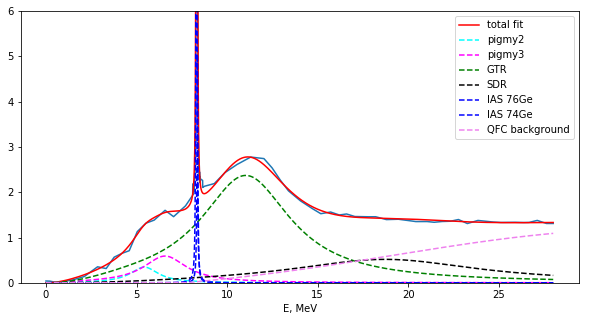

In [24]:
total_mod_comps = total_mod_result.eval_components()

plt.figure(figsize=(10,5))
#plt.plot(data['x'].values, data['y'].values)
plt.plot(data3['x'].values, data3['y'].values)
#plt.plot(temp2['x'].values, temp2['y'].values)
plt.plot(data3['x'].values, total_mod_result.best_fit, 'r-', label='total fit')
plt.plot(data3['x'].values, total_mod_comps['pigmy2_'], 'cyan', label='pigmy2', ls='--')
plt.plot(data3['x'].values, total_mod_comps['pigmy3_'], 'magenta', label='pigmy3', ls='--')
plt.plot(data3['x'].values, total_mod_comps['GTR_'], 'g--', label='GTR')
plt.plot(data3['x'].values, total_mod_comps['SDR_'], 'black', label='SDR', ls='--')
plt.plot(data3['x'].values, total_mod_comps['IAS1_'], 'b--', label='IAS 76Ge')
plt.plot(data3['x'].values, total_mod_comps['IAS2_'], 'b--', label='IAS 74Ge')
plt.plot(data3['x'].values, total_mod_comps['QFC_back_'], 'violet', label='QFC background', ls='--')
#plt.plot(IAS_red['x'].values, comps['line_'], 'b--')
plt.legend()
plt.xlabel('E, MeV')
#plt.ylabel('S(E), 1/MeV')
plt.ylim(0,6)

(0, 6)

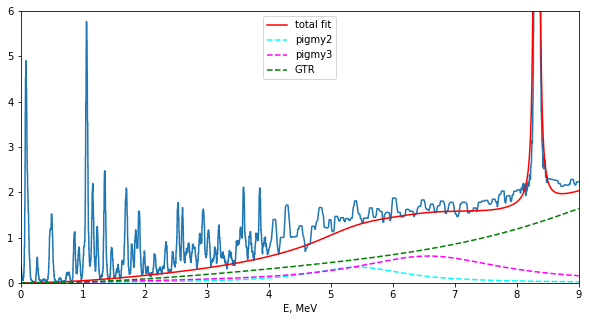

In [25]:
plt.figure(figsize=(10,5))
plt.plot(data['x'].values, data['y'].values)
#plt.plot(data3['x'].values, data3['y'].values)
#plt.plot(temp2['x'].values, temp2['y'].values)
plt.plot(data3['x'].values, total_mod_result.best_fit, 'r-', label='total fit')
plt.plot(data3['x'].values, total_mod_comps['pigmy2_'], 'cyan', label='pigmy2', ls='--')
plt.plot(data3['x'].values, total_mod_comps['pigmy3_'], 'magenta', label='pigmy3', ls='--')
plt.plot(data3['x'].values, total_mod_comps['GTR_'], 'g--', label='GTR')
#plt.plot(data3['x'].values, total_mod_comps['SDR_'], 'black', label='SDR', ls='--')
#plt.plot(data3['x'].values, total_mod_comps['IAS1_'], 'b--', label='IAS 76Ge')
#plt.plot(data3['x'].values, total_mod_comps['IAS2_'], 'b--', label='IAS 74Ge')
#plt.plot(data3['x'].values, total_mod_comps['QFC_back_'], 'violet', label='QFC background', ls='--')
#plt.plot(IAS_red['x'].values, comps['line_'], 'b--')
plt.legend()
plt.xlabel('E, MeV')
plt.xlim(0,9)
plt.ylim(0,6)
#plt.savefig("test.png", transparent=False, dpi=120)

(0, 6)

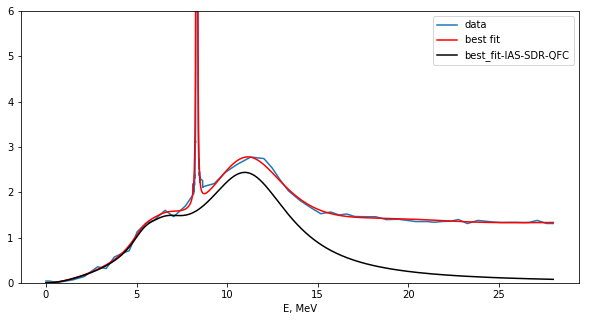

In [26]:
plt.figure(figsize=(10,5))
#plt.plot(data['x'].values, data['y'].values)
plt.plot(data3['x'].values, data3['y'].values, label='data')
#plt.plot(temp2['x'].values, temp2['y'].values)
plt.plot(data3['x'].values, total_mod_result.best_fit, 'r-', label='best fit')
#plt.plot(data3['x'].values, total_mod_comps['pigmy1_'], 'orange', label='pigmy1', ls='--')
#plt.plot(data3['x'].values, total_mod_comps['pigmy2_'], 'cyan', label='pigmy2', ls='--')
#plt.plot(data3['x'].values, total_mod_comps['pigmy3_'], 'magenta', label='pigmy3', ls='--')
#plt.plot(data3['x'].values, total_mod_comps['GTR_'], 'b--')
#plt.plot(data3['x'].values, total_mod_comps['SDR_'], 'b--')
#plt.plot(data3['x'].values, total_mod_comps['IAS1_'], 'b--')
#plt.plot(data3['x'].values, total_mod_comps['IAS2_'], 'b--')
#plt.plot(data3['x'].values, total_mod_comps['QFC_back_'], 'b--')
#plt.plot(data3['x'].values, data3['y'].values-total_mod_result.best_fit )
a = total_mod_comps['QFC_back_']+total_mod_comps['SDR_']+total_mod_comps['IAS1_']+total_mod_comps['IAS2_']
out = total_mod_result.best_fit-a
plt.plot(data3['x'].values, out, c='black', label='best_fit-IAS-SDR-QFC' )
plt.xlabel('E, MeV')
plt.legend()
plt.ylim(0,6)

In [27]:
output=pd.DataFrame(data={'x':data3['x'].values.T, 'y':out.T})
#output.to_csv('2pigmy_best_fit-SDR-IAS-QFC.csv')

(0, 6)

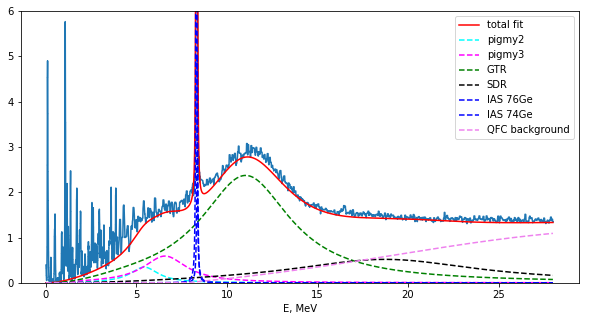

In [28]:
total_mod_comps = total_mod_result.eval_components()

plt.figure(figsize=(10,5))
plt.plot(data['x'].values, data['y'].values)
#plt.plot(data3['x'].values, data3['y'].values)
#plt.plot(temp2['x'].values, temp2['y'].values)
plt.plot(data3['x'].values, total_mod_result.best_fit, 'r-', label='total fit')
plt.plot(data3['x'].values, total_mod_comps['pigmy2_'], 'cyan', label='pigmy2', ls='--')
plt.plot(data3['x'].values, total_mod_comps['pigmy3_'], 'magenta', label='pigmy3', ls='--')
plt.plot(data3['x'].values, total_mod_comps['GTR_'], 'g--', label='GTR')
plt.plot(data3['x'].values, total_mod_comps['SDR_'], 'black', label='SDR', ls='--')
plt.plot(data3['x'].values, total_mod_comps['IAS1_'], 'b--', label='IAS 76Ge')
plt.plot(data3['x'].values, total_mod_comps['IAS2_'], 'b--', label='IAS 74Ge')
plt.plot(data3['x'].values, total_mod_comps['QFC_back_'], 'violet', label='QFC background', ls='--')
#plt.plot(IAS_red['x'].values, comps['line_'], 'b--')
plt.legend()
plt.xlabel('E, MeV')
#plt.ylabel('S(E), 1/MeV')
plt.ylim(0,6)

(0, 15)

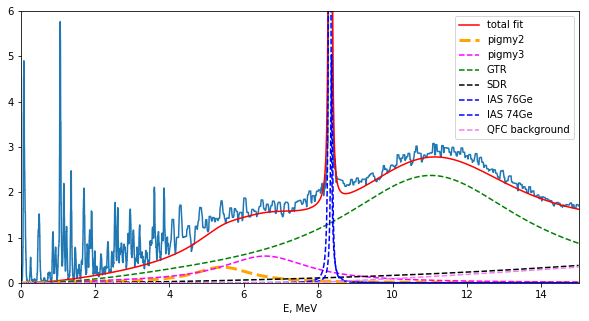

In [29]:
total_mod_comps = total_mod_result.eval_components()

plt.figure(figsize=(10,5))
plt.plot(data['x'].values, data['y'].values)
#plt.plot(data3['x'].values, data3['y'].values)
#plt.plot(temp2['x'].values, temp2['y'].values)
plt.plot(data3['x'].values, total_mod_result.best_fit, 'r-', label='total fit')
plt.plot(data3['x'].values, total_mod_comps['pigmy2_'], 'orange', linewidth=3.0,
         label='pigmy2', ls='--')
plt.plot(data3['x'].values, total_mod_comps['pigmy3_'], 'magenta', label='pigmy3', ls='--')
plt.plot(data3['x'].values, total_mod_comps['GTR_'], 'g--', label='GTR')
plt.plot(data3['x'].values, total_mod_comps['SDR_'], 'black', label='SDR', ls='--')
plt.plot(data3['x'].values, total_mod_comps['IAS1_'], 'b--', label='IAS 76Ge')
plt.plot(data3['x'].values, total_mod_comps['IAS2_'], 'b--', label='IAS 74Ge')
plt.plot(data3['x'].values, total_mod_comps['QFC_back_'], 'violet', label='QFC background', ls='--')
#plt.plot(IAS_red['x'].values, comps['line_'], 'b--')
plt.legend()
plt.xlabel('E, MeV')
#plt.ylabel('S(E), 1/MeV')
plt.ylim(0,6)
plt.xlim(0,15)
#plt.savefig("all_fit_0_15.png", transparent=False, dpi=120)

In [39]:
#np.random.seed(250)

total_mod = Model(breit_vigner3,prefix='pigmy1_') \
+Model(breit_vigner3,prefix='pigmy2_') \
+Model(breit_vigner3,prefix='pigmy3_') \
+Model(breit_vigner3,prefix='pigmy4_') \
+Model(breit_vigner3,prefix='IAS1_') \
+Model(breit_vigner3,prefix='IAS2_') \
+Model(breit_vigner3, prefix='GTR_') \
+Model(breit_vigner3, prefix='SDR_') \
+Model(QFC_back3, prefix='QFC_back_')

total_mod.set_param_hint('pigmy1_w', value=3.83, min=3, max=4)
total_mod.set_param_hint('pigmy1_G1', value=0.1, min=0.1, max=1)
total_mod.set_param_hint('pigmy1_M', value=0.1, min=0.1, max=0.6)

total_mod.set_param_hint('pigmy2_w', value=4.39, min=4, max=5)
total_mod.set_param_hint('pigmy2_G1', value=0.1, min=0.1, max=1)
total_mod.set_param_hint('pigmy2_M', value=0.1, min=0.1, max=0.6)

total_mod.set_param_hint('pigmy3_w', value=5.49, min=5, max=6)
total_mod.set_param_hint('pigmy3_G1', value=0.1, min=0.1, max=1.5)
total_mod.set_param_hint('pigmy3_M', value=0.1, min=0.1, max=1)

total_mod.set_param_hint('pigmy4_w', value=6.86, min=6, max=7)
total_mod.set_param_hint('pigmy4_G1', value=0.1, min=0.1, max=2)
total_mod.set_param_hint('pigmy4_M', value=0.1, min=0.1, max=1.5)

total_mod.set_param_hint('IAS1_w', value=8.308, vary=False)
total_mod.set_param_hint('IAS1_G1', value=0.01, min=0.01, max=0.02)
total_mod.set_param_hint('IAS1_M', value=0.5, min=0.5, max=0.7)
total_mod.set_param_hint('IAS2_w', value=8.36, vary=False)
total_mod.set_param_hint('IAS2_G1', value=0.03, min=0.01, max=0.05)
total_mod.set_param_hint('IAS2_M', value=0.1, min=0.1, max=0.5)

total_mod.set_param_hint('GTR_w', value=11.0, min=11, max=11.5)
total_mod.set_param_hint('GTR_G1', value=2, min=2, max=4)
total_mod.set_param_hint('GTR_M', value=0.5, min=0.1, max= 50)

total_mod.set_param_hint('SDR_w', value=18.5, min=18, max=19)
total_mod.set_param_hint('SDR_G1', value=0.01, min=0.1, max=10)
total_mod.set_param_hint('SDR_M', value=0.5, min=0.1, max= 5)

total_mod.set_param_hint('QFC_back_E_qf', value=400, max=410, min=380 )
total_mod.set_param_hint('QFC_back_N_0', value=8, max=15, min=1 )
total_mod.set_param_hint('QFC_back_W', value=22, vary=False)
total_mod.set_param_hint('QFC_back_T', value=100,vary=False)

pars = total_mod.make_params()



In [40]:
total_mod_result = total_mod.fit(data3['y'].values, pars, x=data3['x'].values, 
                                 method='differential_evolution')

print(total_mod_result.fit_report())

[[Model]]
    ((((((((Model(breit_vigner3, prefix='pigmy1_') + Model(breit_vigner3, prefix='pigmy2_')) + Model(breit_vigner3, prefix='pigmy3_')) + Model(breit_vigner3, prefix='pigmy4_')) + Model(breit_vigner3, prefix='IAS1_')) + Model(breit_vigner3, prefix='IAS2_')) + Model(breit_vigner3, prefix='GTR_')) + Model(breit_vigner3, prefix='SDR_')) + Model(QFC_back3, prefix='QFC_back_'))
[[Fit Statistics]]
    # function evals   = 77561
    # data points      = 4893
    # variables        = 24
    chi-square         = 153.108
    reduced chi-square = 0.031
    Akaike info crit   = -16903.395
    Bayesian info crit = -16747.502
[[Variables]]
    pigmy1_M:        0.10986535 (init= 0.1)
    pigmy1_w:        3.91031548 (init= 3.83)
    pigmy1_G1:       0.85898885 (init= 0.1)
    pigmy2_M:        0.10344974 (init= 0.1)
    pigmy2_w:        4.98924791 (init= 4.39)
    pigmy2_G1:       0.41015874 (init= 0.1)
    pigmy3_M:        0.15809853 (init= 0.1)
    pigmy3_w:        5.71471975 (init= 5.49)
  

(0, 10)

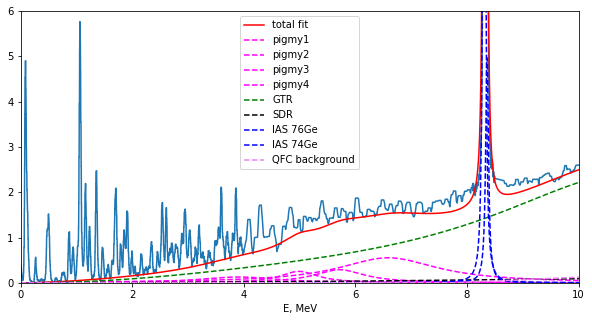

In [42]:
total_mod_comps = total_mod_result.eval_components()

plt.figure(figsize=(10,5))
plt.plot(data['x'].values, data['y'].values)
#plt.plot(data3['x'].values, data3['y'].values)
#plt.plot(temp2['x'].values, temp2['y'].values)
plt.plot(data3['x'].values, total_mod_result.best_fit, 'r-', label='total fit')
plt.plot(data3['x'].values, total_mod_comps['pigmy1_'], 'magenta', label='pigmy1', ls='--')
plt.plot(data3['x'].values, total_mod_comps['pigmy2_'], 'magenta', label='pigmy2', ls='--')
plt.plot(data3['x'].values, total_mod_comps['pigmy3_'], 'magenta', label='pigmy3', ls='--')
plt.plot(data3['x'].values, total_mod_comps['pigmy4_'], 'magenta', label='pigmy4', ls='--')
plt.plot(data3['x'].values, total_mod_comps['GTR_'], 'g--', label='GTR')
plt.plot(data3['x'].values, total_mod_comps['SDR_'], 'black', label='SDR', ls='--')
plt.plot(data3['x'].values, total_mod_comps['IAS1_'], 'b--', label='IAS 76Ge')
plt.plot(data3['x'].values, total_mod_comps['IAS2_'], 'b--', label='IAS 74Ge')
plt.plot(data3['x'].values, total_mod_comps['QFC_back_'], 'violet', label='QFC background', ls='--')
#plt.plot(IAS_red['x'].values, comps['line_'], 'b--')
plt.legend()
plt.xlabel('E, MeV')
#plt.ylabel('S(E), 1/MeV')
plt.ylim(0,6)
plt.xlim(0,10)
#plt.savefig("all_fit_0_15.png", transparent=False, dpi=120)